### pytorch 예제
https://github.com/bjpublic/DeepLearningProject/blob/main/03_%EC%86%90%EA%B8%80%EC%94%A8_%EC%88%AB%EC%9E%90_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98/mnist_example.ipynb

In [25]:
#!pip install torchsummary

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# from torch.autograd import Variable

from matplotlib import pyplot as plt
%matplotlib inline

#### pytorch 장치 할당
https://tutorials.pytorch.kr/recipes/recipes/save_load_across_devices.html

In [2]:
#### -- 1-2. 분석 환경 설정 -- ####

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

# torch.device('cpu') cpu할당
# torch.device('cuda') gpu 할당

print ('Current cuda device is', device)

Current cuda device is cuda


In [3]:
#### -- 1-3. Hyper-parameter 지정 -- ####
batch_size = 50
learning_rate = 0.0001
epoch_num = 15

In [5]:
#### -- 2-1. MNIST 데이터 불러오기 -- ####
train_data = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor())

print('number of training data: ', len(train_data))
print('number of test data: ', len(test_data))

100%|██████████| 9912422/9912422 [00:01<00:00, 9453855.34it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 11522466.83it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6889888.96it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

number of training data:  60000
number of test data:  10000


In [6]:
#### -- 2-2. MNIST 데이터 확인하기 -- ####
image, label = train_data[0]
image.shape, image.squeeze().shape, image.squeeze().numpy().shape
# matplot에 이미지를 그리기 위해서는 흑백의 경우 (28,28), 컬러의 경우 (28,28,3)
# matplot으로 그리기 위해 차원축소를 하고자 squeeze함수를 사용함(1의 차원만 제거)

(torch.Size([1, 28, 28]), torch.Size([28, 28]), (28, 28))

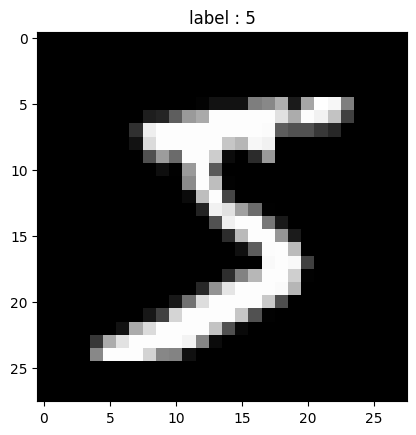

In [7]:
plt.imshow(image.squeeze().numpy(), cmap = 'gray')
# numpy말고 squeeze만 적용한 값을 사용해도 됨, torch의 경우 가능
# squeeze : 1의 차원만 제거, 차원 축소
#  
plt.title('label : %s' % label)
plt.show()

##### 내 폴더 자료 불러와서 x,y 데이터셋 구성하기
    - 폴더 내의 자료를 x 데이터로 부르면서 array화 함
    https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html

In [37]:
#### -- 2-3. Mini-Batch 구성하기 -- ####
train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                           batch_size = batch_size, shuffle = True)
test_loader  = torch.utils.data.DataLoader(dataset = test_data, 
                                           batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__() # 첫번째 데이터 읽기, tensorflow : iteration(next)
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

# batch에는 img, label이 들어있으므로 len(first_batch)=2

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])


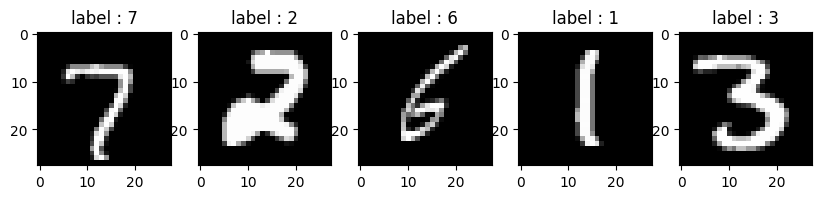

In [38]:
first_batch[0].min(), first_batch[0].max(), first_batch[1]
# 정규화 확인

dataNum=5
cnt=1
plt.figure(figsize=(10,3))
for x,y in zip(first_batch[0][:dataNum], first_batch[1][:dataNum]):
    print(x.squeeze().shape)
    plt.subplot(1,5,cnt)
    plt.imshow(x.squeeze().numpy(), cmap = 'gray')
    plt.title('label : %s' % y.numpy())
    cnt+=1
plt.show()

In [39]:
#### -- 3-1. CNN 구조 설계하기 (매우 중요) -- ####
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)  # 최종 output 10개

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [40]:
#### -- 3-2. Optimizer 및 손실함수 정의 -- ####
model = CNN().to(device)  # class를 설정하여 device에 넘김
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss( )
# softmax output은 10개 이므로 crossentropy 사용

In [35]:
#### -- 3-3. 설계한 CNN 모형 확인하기 -- ####
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [23]:
import torchsummary
torchsummary.summary(model, (1,28,28))
# flatten 전의 output 구성 확인 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
         Dropout2d-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
         Dropout2d-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 4.58
Estimated Total Size (MB): 5.10
----------------------------------------------------------------


In [14]:
#### -- 3-4. 모델 학습하기 -- ###
model.train()
i = 1
for epoch in range(epoch_num):
    cost=0
    
    for data, target in train_loader:
        data = data.to(device) # data를 device에 넘김
        target = target.to(device)
        optimizer.zero_grad() # 경사하강
        output = model(data)
        loss = criterion(output, target) # 오차 계산
        loss.backward() # 오차 역전파
        optimizer.step() # optimizer를 오차 역전파에 의해 step별로 진행
        if i % 1000 == 0: # 1000번에 1번, batchsize만큼 도는데 1000번에 1번씩 print함, earlystopping과 같은 조건도 넣어줄 수 있음
            # i : batch 1개, 전체 batch 1200개
            # i % 1200이면 epoch 한번당 결과 반환과 같음
            print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.item()))
        i += 1

Train Step: 1000	Loss: 0.285
Train Step: 2000	Loss: 0.043
Train Step: 3000	Loss: 0.335
Train Step: 4000	Loss: 0.279
Train Step: 5000	Loss: 0.100
Train Step: 6000	Loss: 0.120
Train Step: 7000	Loss: 0.098
Train Step: 8000	Loss: 0.017
Train Step: 9000	Loss: 0.129
Train Step: 10000	Loss: 0.175
Train Step: 11000	Loss: 0.049
Train Step: 12000	Loss: 0.074
Train Step: 13000	Loss: 0.025
Train Step: 14000	Loss: 0.052
Train Step: 15000	Loss: 0.050
Train Step: 16000	Loss: 0.050
Train Step: 17000	Loss: 0.020
Train Step: 18000	Loss: 0.028


In [15]:
#### -- 4. 모델 평가하기 -- ###
model.eval()
correct = 0
for data, target in test_loader:
#     data, target = Variable(data, volatile=True), Variable(target)
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('Test set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

Test set: Accuracy: 99.05%


In [92]:
loss_list = []
accuracy_list = []
epoch_list = []
total_batch=len(train_loader)

model.train()

for epoch in range(epoch_num):
    cost=0
    
    for data, target in train_loader:
        data = data.to(device) # data를 device에 넘김
        target = target.to(device)
        optimizer.zero_grad() # 경사하강
        output = model(data)
        loss = criterion(output, target) # 오차 계산
        loss.backward() # 오차 역전파
        optimizer.step()
        
        cost += loss
    
    with torch.no_grad(): #미분하지 않겠다는 것
        total = 0
        correct=0
        for data, target in test_loader:
        #     data, target = Variable(data, volatile=True), Variable(target)
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            prediction = output.data.max(1)[1]

            total += target.size(0)
            correct += prediction.eq(target.data).sum()

    avg_cost = cost / total_batch
    accuracy = 100*correct/total
    
    # loss_list.append(avg_cost.detach().numpy())
    loss_list.append(avg_cost.item())
    accuracy_list.append(accuracy.item())
    epoch_list.append(epoch)
    
    print("epoch : {} | loss : {:.6f}" .format(epoch, avg_cost))
    print("Accuracy : {:.2f}".format(100*correct/total))
    print("------")

c:\Users\user\miniconda3\envs\gpu\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch : 0 | loss : 0.018824
Accuracy : 98.56
------
epoch : 1 | loss : 0.017085
Accuracy : 98.58
------
epoch : 2 | loss : 0.017439
Accuracy : 98.60
------
epoch : 3 | loss : 0.016959
Accuracy : 98.59
------
epoch : 4 | loss : 0.017494
Accuracy : 98.64
------
epoch : 5 | loss : 0.016524
Accuracy : 98.53
------
epoch : 6 | loss : 0.015523
Accuracy : 98.42
------
epoch : 7 | loss : 0.016178
Accuracy : 98.47
------
epoch : 8 | loss : 0.015002
Accuracy : 98.60
------
epoch : 9 | loss : 0.015592
Accuracy : 98.39
------
epoch : 10 | loss : 0.015246
Accuracy : 98.45
------
epoch : 11 | loss : 0.015623
Accuracy : 98.70
------
epoch : 12 | loss : 0.014426
Accuracy : 98.56
------
epoch : 13 | loss : 0.013800
Accuracy : 98.43
------
epoch : 14 | loss : 0.013790
Accuracy : 98.48
------


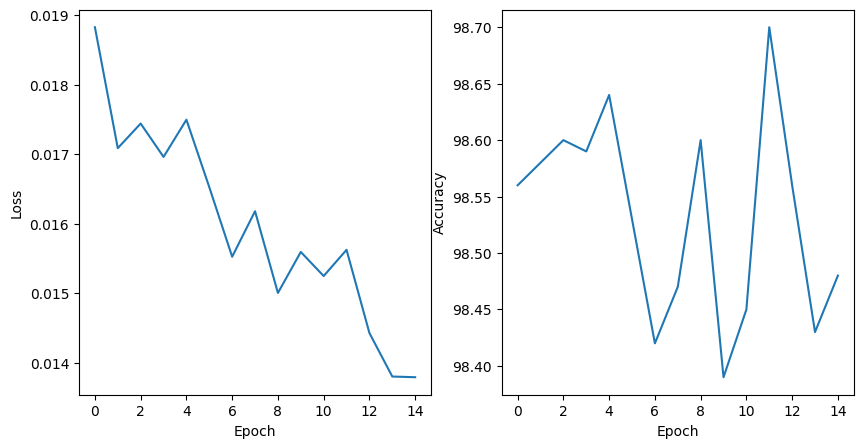

In [93]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoch_list,loss_list)
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epoch_list, accuracy_list)
plt.show()

In [29]:
correct

tensor(9905, device='cuda:0')

In [30]:
prediction.eq(target.data)

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')